# Принятие решений в бизнесе на основе данных

Мы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

### Вступление
У нас есть данные двух файлов. В первом находятся 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Во втором - результаты A/B-теста, который необходимо проанализировать, сделать соответствующие выводы и составить рекомендации.

Цель работы: приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты, сделать соответствующие выводы и составить рекомендации.

Для достижения поставленных целей необходимо применить фреймворк ICE и RICE для приоритизации гипотез, построить графики кумулятивных выручки, среднего чека и конверсии по группам, посчитать перцентили количества заказов на пользователя, выбрать границу для определения аномальных пользователе, посчитать статистическую значимость различий и принять решения по результатам теста.

Описание данных:

##### Таблица hypothesis (9 гипотез по увеличению выручки интернет-магазина с указанными параметрами):
- *Hypothesis* — краткое описание гипотезы
- *Reach* — охват пользователей по 10-балльной шкале
- *Impact* — влияние на пользователей по 10-балльной шкале
- *Confidence* — уверенность в гипотезе по 10-балльной шкале
- *Efforts* — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

##### Таблица orders (информация о заказах):
- *transactionId* — идентификатор заказа
- *visitorId* — идентификатор пользователя, совершившего заказ
- *date* — дата, когда был совершён заказ
- *revenue* — выручка заказа
- *group* — группа A/B-теста, в которую попал заказ.

##### Таблица visitors (данные о количестве пользователей групп тестирования в выделенный диапазон дат):
- *date* — дата
- *group* — группа A/B-теста
- *visitors* — количество пользователей в указанную дату в указанной группе A/B-теста.

### Часть 1. Приоритизация гипотез.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

Откроем файл с данными и взглянем на его содержимое

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Все данные есть, они чистые, никаких пропущенных значений и дубликатов.
Данные готовы для дальнейшей работы.

Применим фреймворк ICE:

In [3]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
print(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

                                          Hypothesis        ICE
8  Запустить акцию, дающую скидку на товар в день...  16.200000
0  Добавить два новых канала привлечения трафика,...  13.333333
7  Добавить форму подписки на все основные страни...  11.200000
6  Показать на главной странице баннеры с актуаль...   8.000000
2  Добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  Запустить собственную службу доставки, что сок...   2.000000
5  Добавить страницу отзывов клиентов о магазине,...   1.333333
3  Изменить структура категорий, что увеличит кон...   1.125000
4  Изменить цвет фона главной страницы, чтобы уве...   1.000000


Наиболее перспективные гипотезы скрываются под индексами 8, 0, 7, 6.

Аналогично применим фреймворк RICE:

In [4]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
print(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                          Hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


Теперь наиболее перспективными гипотезами вправе считаться те, что под индексами 7, 2, 0, 6.

Приоретизация изменилась за счет того, что параметр Reach максимален у 7й гипотезы, а у второй гипотезы он имеет значение 8 (по 10-балльной шкале). А у 8й гипотезы он как раз имеет минимальное значение из возможных. Количество пользователей, которое затронет потенциальное изменение, сыграло одну из основополагающих ролей, чем и вызвало это изменение.

### Часть 2. Анализ A/B-теста

Откроем файлы с данными и взглянем на их содержимое

In [5]:
orders = pd.read_csv('/datasets/orders.csv')
orders.info()
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [6]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()
visitors.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Переведём строку с датой в формат даты для обеих таблиц

In [7]:
import datetime as dt

visitors["date"] = visitors["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders["date"] = orders["date"].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

visitors.info()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Данные подготовлены для дальнейшего анализа.

1. Построить график кумулятивной выручки по группам. Сделать выводы и предположения.

In [8]:
# создадим таблицу уникальных сочетаний дат и групп
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# агрегированные кумулятивные данные о посетителях
visitorsAggregated = datesGroups.apply(
lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем данные из двух таблиц
cummulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# добавим столбец, где посчитаем конверсию
cummulativeData['conversion'] = cummulativeData['orders'] / cummulativeData['visitors']

# разделим наш датафрейм на два - по группам А и В
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']

Взглянем на получившиеся таблицы

In [9]:
cummulativeDataA.head(10)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856
6,2019-08-04,A,84,77,425699,2562,0.032787
8,2019-08-05,A,109,100,549917,3318,0.032851
10,2019-08-06,A,127,114,598401,3985,0.031870
12,2019-08-07,A,145,131,740818,4629,0.031324
14,2019-08-08,A,161,146,837097,5239,0.030731
16,2019-08-09,A,177,159,1025603,5856,0.030225
18,2019-08-10,A,193,175,1236098,6262,0.030821


In [10]:
cummulativeDataB.head(10)

,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,21,20,101217,713,0.029453
3,2019-08-02,B,45,43,266748,1294,0.034776
5,2019-08-03,B,61,59,380996,1803,0.033833
7,2019-08-04,B,78,75,489567,2573,0.030315
9,2019-08-05,B,101,98,581995,3280,0.030793
11,2019-08-06,B,129,123,824337,3935,0.032783
13,2019-08-07,B,153,146,1049671,4644,0.032946
15,2019-08-08,B,180,171,1270589,5298,0.033975
17,2019-08-09,B,205,193,1431401,5908,0.034699
19,2019-08-10,B,228,215,1539203,6277,0.036323


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


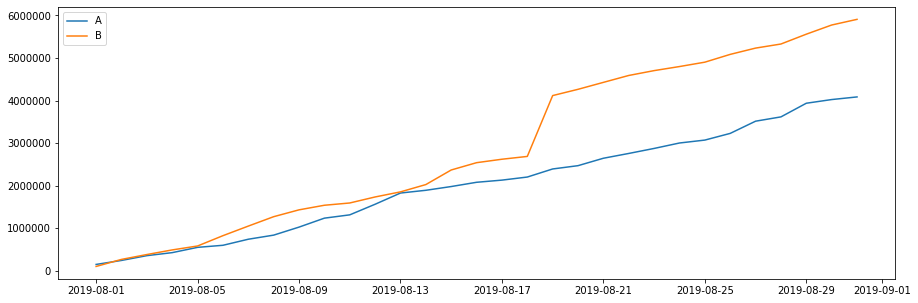

In [11]:
# Построим графики комулятивной выручки
plt.figure(figsize=(15,5))
plt.plot(cummulativeDataA['date'], cummulativeDataA['revenue'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['revenue'], label='B')
plt.legend()

У группы B и без того кумулятивная выручка оказалась выше, так еще и 19 августа произошел существенный скачок. Есть большая вероятность, что на эту (и не только) дату сможем выявить аномально высокие показатели, являющиеся выбросами.

2. Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.

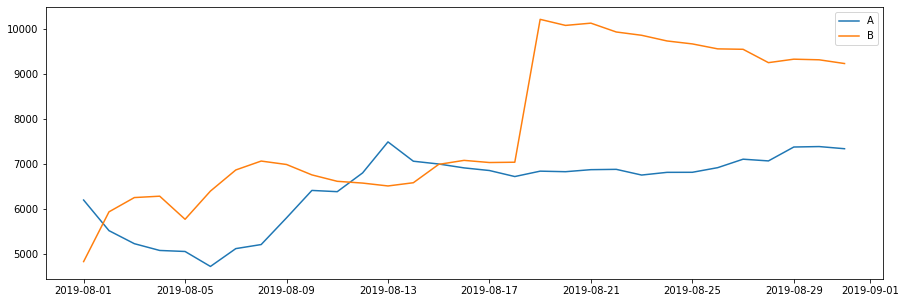

In [12]:
plt.figure(figsize=(15,5))
plt.plot(cummulativeDataA['date'], cummulativeDataA['revenue'] / cummulativeDataA['orders'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['revenue'] / cummulativeDataB['orders'], label='B')
plt.legend()

Наши опасения по поводу 19 августа пока подтверждаются. А в целом, картина по средним чекам носит непостоянный характер, и какие-либо выводы исходя из графика делать не стоит.

3. Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.

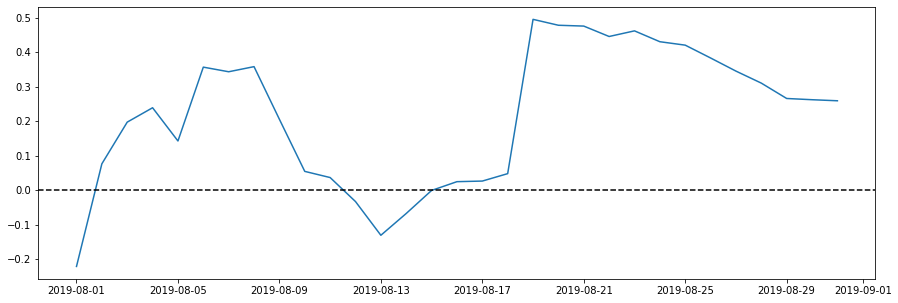

In [13]:
# собираем данные в одном датафрейме
mergedCummulativeRevenue = cummulativeDataA.merge(cummulativeDataB, on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15,5))
plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['revenueB'] / mergedCummulativeRevenue['ordersB']) / (mergedCummulativeRevenue['revenueA'] / mergedCummulativeRevenue['ordersA']) - 1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')


Есть резкие скачки, причем в несколько дат. Несложно сделать предположение, что именно в это время были сделаны аномальные покупки.

4. Построить график кумулятивной конверсии по группам. Сделать выводы и предположения.

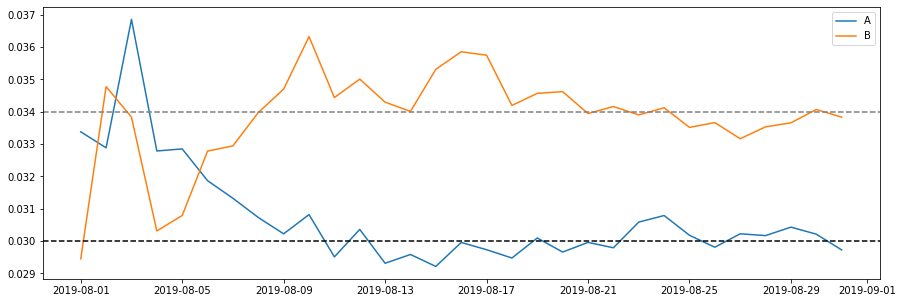

In [14]:
plt.figure(figsize=(15,5))
plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')
plt.legend()
plt.axhline(y=0.03, color='black', linestyle='--')
plt.axhline(y=0.034, color='grey', linestyle='--')

У обеих групп конверсия была аномально высокая 2-3 августа, в итоге у группы она стала падать до среднего значения в районе 3%, а у группы В она стала расти до среднего значения в районе 3.4%

5. Построить график относительного изменения кумулятивной конверсии группы B к группе A. Сделать выводы и предположения

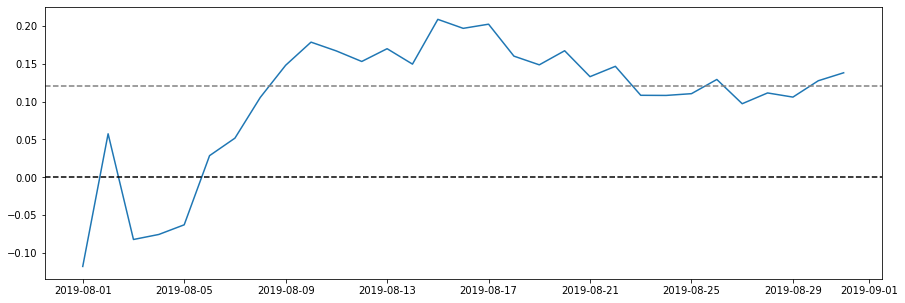

In [15]:
# Внесём данные по конверсиям в один датафрейм, где на каждую дату будет групповая пара значений конверсий
mergedCummConversions = cummulativeDataA[['date','conversion']].merge(cummulativeDataB[['date','conversion']], on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))
plt.plot(mergedCummConversions['date'], mergedCummConversions['conversionB'] / mergedCummConversions['conversionA'] - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.12, color='grey', linestyle='--')

Соперничая на равных с группой А в течение первых шести дней группа В стала лидировать по конверсии относительно группы А, выйдя с 22 августа на плато с показателем 12%

6. Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.

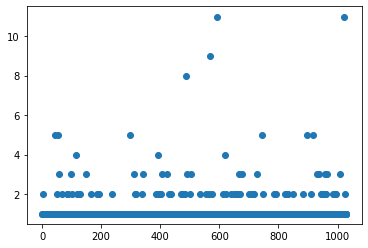

In [16]:
# сгруппируем данные транзацкций по пользователям
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns = ['visitorId','orders']

# В качестве значений оси Х возьмем все целочисленные значения до максимального индекса, в качестве значений Y - столбец заказов
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])

Подавляющее большинство пользователей совершило по 1 заказу. Рост количества заказов на пользователя далее идёт по убывающей. Однако видим, что есть 2 аномальных пользователя, совершивших по 11 заказов. Чтобы определить выбросы, разобьём наши значения на перцентили. Предположим, что выборсы будут расположены выше 95го перцентиля.

7. Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.

In [17]:
print('Выберем', int(np.percentile(ordersByUsers['orders'], [90, 95, 99])[1]), 'заказа на одного пользователя за верхнюю границу числа заказов. Всё, что больше этого количества, является выбросами.')
np.percentile(ordersByUsers['orders'], [90, 95, 99])

Выберем 2 заказа на одного пользователя за верхнюю границу числа заказов. Всё, что больше этого количества, является выбросами.


array([1., 2., 4.])

8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

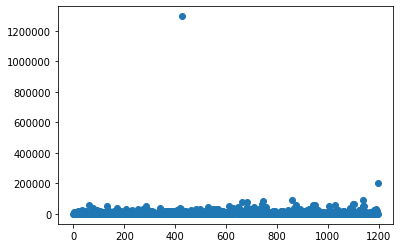

In [18]:
# В качестве значений оси Х возьмем все целочисленные значения до максимального индекса, в качестве значений Y - стоимости заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

На графике мы видим пару заказов, которые "отбились" от основной массы показателей. Остаётся теперь разобраться с выбросами. Так же определимся, что выборсы будут расположены выше 95го перцентиля.


9. Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.

In [19]:
print('Выберем значение стоимости заказа', int(np.percentile(orders['revenue'], [90, 95, 99])[1]), ' за верхнюю границу. Всё, что больше этой стоимости, является выбросами.')
np.percentile(orders['revenue'], [90, 95, 99])

Выберем значение стоимости заказа 28000  за верхнюю границу. Всё, что больше этой стоимости, является выбросами.


array([18168. , 28000. , 58233.2])

10. Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным. Сделать выводы и предположения.

In [20]:
# Количество посетителей на каждый день
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Кумулятивный подсчет посетителей
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# Количество посетителей на каждый день
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# Кумулятивный подсчет посетителей
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# Группируем по дням, рассчитываем для каждого уникального посетителя суммарную дневную выручку.
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']].groupby('date', as_index=False).agg({'transactionId': 'nunique', 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# Кумулятивный подсчёт количества заказов и суммарной выручку по дням
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]\
    .agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by='date')
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

# Группируем по дням, рассчитываем для каждого уникального посетителя суммарную дневную выручку.
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']].groupby('date', as_index=False)\
    .agg({'transactionId': 'nunique', 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# Кумулятивный подсчёт количества заказов и суммарной выручку по дням
ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]\
    .agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1).sort_values(by='date')
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

# Объединяем все полученные таблицы, где будет вся сводная информация на каждую конкретную дату
data = ordersADaily.merge(ordersBDaily, on='date', how='left')\
    .merge(ordersACummulative, on='date', how='left')\
    .merge(ordersBCummulative, on='date', how='left')\
    .merge(visitorsADaily, on='date', how='left')\
    .merge(visitorsBDaily, on='date', how='left')\
    .merge(visitorsACummulative, on='date', how='left')\
    .merge(visitorsBCummulative, on='date', how='left')

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [21]:
# Сгруппируем по пользователям количество уникальных заказов
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsersB.columns = ['userId', 'orders']

alpha = 0.05
# Объединение последовательностей
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

# Применяем критерий Манна-Уитни для проверки гипотезы о статистической значимости различий конверсий и выводим результат.
p_value = st.mannwhitneyu(sampleA, sampleB)[1]
print("p-value = {0:.3f}".format(p_value))
if p_value < alpha:
    print('Отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть.')
else:
    print('Не отвергаем нулевую гипотезу. Статистически значимых различий в конверсии между группами нет.')
print("Относительный прирост конверсии группы В к группе А равен {0:.2%}".format(sampleB.mean()/sampleA.mean()-1))

p-value = 0.008
Отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть.
Относительный прирост конверсии группы В к группе А равен 13.81%


Если есть различия в конверсии, значит группа В отличается от группы А, а положительный прирост конверсии говорит о превосходстве группы В над группой А. Впрочем, необходимо смотреть результаты после очистки данных.

11. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать  выводы и предположения.

In [22]:
p_value = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print("p-value = {0:.3f}".format(p_value))
if p_value < alpha:
    print('Отвергаем нулевую гипотезу. Статистически значимые различия в средних чеках между группами есть.')
else:
    print('Не отвергаем нулевую гипотезу. Статистически значимых различий в средних чеках между группами нет.')
print("Относительный прирост среднего чека группы В к группе А равен {0:.2%}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.365
Не отвергаем нулевую гипотезу. Статистически значимых различий в средних чеках между группами нет.
Относительный прирост среднего чека группы В к группе А равен 25.87%


Средние чеки при всей своей статистической схожести приносят больший средний прирост. Посмотрим на очищенные данные.

12. Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделать выводы и предположения.

In [23]:
# Выделим аномальных пользователей по определенным ранее критериям
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], [90, 95, 99])[1]]['userId'], ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], [90, 95, 99])[1]]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [90, 95, 99])[1]]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

# Отфильтруем наши "сырые" данные на основе выделенных аномальных пользователей
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

p_value = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print("p-value = {0:.5f}".format(p_value))
if p_value < alpha:
    print('Отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть.')
else:
    print('Не отвергаем нулевую гипотезу. Статистически значимых различий в конверсии между группами нет.')

print("Относительный прирост конверсии группы В к группе А равен {0:.2%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.00652
Отвергаем нулевую гипотезу. Статистически значимые различия в конверсии между группами есть.
Относительный прирост конверсии группы В к группе А равен 17.27%


Относительный прирост конверсии еще выше после очистки. Значит изменения, свойственные группе В положительно повлияли на показатели выручки.

13. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.

In [24]:
p_value = st.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],\
    orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]
print("p-value = {0:.5f}".format(p_value))
if p_value < alpha:
    print('Отвергаем нулевую гипотезу. Статистически значимые различия в средних чеках между группами есть.')
else:
    print('Не отвергаем нулевую гипотезу. Статистически значимых различий в средних чеках между группами нет.')
print("Относительный прирост среднего чека группы В к группе А равен {0:.2%}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value = 0.36924
Не отвергаем нулевую гипотезу. Статистически значимых различий в средних чеках между группами нет.
Относительный прирост среднего чека группы В к группе А равен -1.96%


После очистки данных картина поменялась на противоположную. Средний чек группы В ниже, чем в группе А. Версия тут одна - взяли количеством, а меньший средний чек может говорить о том, что пользователей группы В привлекли скидками

14. Принять решение по результатам теста и объяснить его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

По конверсии группа В превосходит группу А, в то время как после очистки данных мы видим картину, где средний чек в группе В ниже, чем в А. Это говорит о том, что при изменениях, свойственных группе В, покупать стали больше, но средний чек при этом упал почти на 2%. По графику различия конверсий мы видим превосходство результатов группы В, которые вначале росли, затем зафиксировались на уровне среднего значения, равному 12%. График различия средних чеков позволил выявить наличие аномалий. На нём отчётливо видны скачки, скрывающие реальное положение вещей.
Если мы обратимся к размеру выборок по группам, то обнаружим, что в выборке В изначально больше транзакций (640 против 557), что и внесло свои коррективы к проверке гипотез.
Рекомендуется к принятию решение: продолжить тест до накопления нужного числа наблюдений.